# Phase 4 – Evaluation Demo (Christian)

This notebook reuses the Phase 3 MLP model and focuses on:
- Final evaluation metrics (MAE, RMSE) vs baseline & linear regression  
- Computing 0–100 “overall scores” for each county  
- Listing and visualizing the top-scoring counties
- This Phase 4 notebook uses the final MLP (log-target) model from Phase 3 and evaluates it against a global median baseline and linear regression



In [1]:
# Imports and configuration
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 200)

## Load CSV

In [54]:
from pathlib import Path
import pandas as pd

# Show where this notebook is running from (for sanity)
print("CWD:", Path().resolve())

# Use repo-relative path so it works on any machine
csv_path = Path("Data 2") / "final_with_proficiency_christian.csv"
print("CSV path:", csv_path.resolve())

df = pd.read_csv(csv_path)
df.shape



CWD: /Users/christian/Desktop/Phase 3 
CSV path: /Users/christian/Desktop/Phase 3 /Data 2/final_with_proficiency_christian.csv


FileNotFoundError: [Errno 2] No such file or directory: 'Data 2/final_with_proficiency_christian.csv'

## Inspect Data

In [3]:
df.head()

,RegionID_zhvi,SizeRank_zhvi,RegionName,RegionType_zhvi,StateName_zhvi,STATE,City_zhvi,Metro_zhvi,CountyName_zhvi,1/31/00,2/29/00,3/31/00,4/30/00,5/31/00,6/30/00,7/31/00,8/31/00,9/30/00,10/31/00,11/30/00,12/31/00,1/31/01,2/28/01,3/31/01,4/30/01,5/31/01,6/30/01,7/31/01,8/31/01,9/30/01,10/31/01,11/30/01,12/31/01,1/31/02,2/28/02,3/31/02,4/30/02,5/31/02,6/30/02,7/31/02,8/31/02,9/30/02,10/31/02,11/30/02,12/31/02,1/31/03,2/28/03,3/31/03,4/30/03,5/31/03,6/30/03,7/31/03,8/31/03,9/30/03,10/31/03,11/30/03,12/31/03,1/31/04,2/29/04,3/31/04,4/30/04,5/31/04,6/30/04,7/31/04,8/31/04,9/30/04,10/31/04,11/30/04,12/31/04,1/31/05,2/28/05,3/31/05,4/30/05,5/31/05,6/30/05,7/31/05,8/31/05,9/30/05,10/31/05,11/30/05,12/31/05,1/31/06,2/28/06,3/31/06,4/30/06,5/31/06,6/30/06,7/31/06,8/31/06,9/30/06,10/31/06,11/30/06,12/31/06,1/31/07,2/28/07,3/31/07,4/30/07,5/31/07,6/30/07,7/31/07,...,2020-09-30_zori,2020-10-31_zori,2020-11-30_zori,2020-12-31_zori,2021-01-31_zori,2021-02-28_zori,2021-03-31_zori,2021-04-30_zori,2021-05-31_zori,2021-06-30_zori,2021-07-31_zori,2021-08-31_zori,2021-09-30_zori,2021-10-31_zori,2021-11-30_zori,2021-12-31_zori,2022-01-31_zori,2022-02-28_zori,2022-03-31_zori,2022-04-30_zori,2022-05-31_zori,2022-06-30_zori,2022-07-31_zori,2022-08-31_zori,2022-09-30_zori,2022-10-31_zori,2022-11-30_zori,2022-12-31_zori,2023-01-31_zori,2023-02-28_zori,2023-03-31_zori,2023-04-30_zori,2023-05-31_zori,2023-06-30_zori,2023-07-31_zori,2023-08-31_zori,2023-09-30_zori,2023-10-31_zori,2023-11-30_zori,2023-12-31_zori,2024-01-31_zori,2024-02-29_zori,2024-03-31_zori,2024-04-30_zori,2024-05-31_zori,2024-06-30_zori,2024-07-31_zori,2024-08-31_zori,2024-09-30_zori,2024-10-31_zori,2024-11-30_zori,2024-12-31_zori,2025-01-31_zori,2025-02-28_zori,2025-03-31_zori,2025-04-30_zori,2025-05-31_zori,2025-06-30_zori,2025-07-31_zori,2025-08-31_zori,2025-09-30_zori,NMCNTY_x,latest_home_value,latest_rent,CountyName,crime_rate_per_100000,CPOPARST,CPOPCRIM,AG_ARRST,AG_OFF,COVIND,INDEX,MODINDX,MURDER,RAPE,ROBBERY,AGASSLT,BURGLRY,LARCENY,MVTHEFT,ARSON,population,FIPS_ST,FIPS_CTY,NMCNTY_y,CountySchoolScore_y,PCT_CITY11_y,PCT_CITY12_y,PCT_CITY13_y,PCT_SUB21_y,PCT_SUB22_y,PCT_SUB23_y,PCT_TOWN31_y,PCT_TOWN32_y,PCT_TOWN33_y,PCT_RURAL41_y,PCT_RURAL42_y,PCT_RURAL43_y,NMCNTY,Proficiency
0,91982,1,77494,zip,TX,TX,Katy,"Houston-The Woodlands-Sugar Land, TX",Fort Bend County,211260.03610,211443.39070,211933.33620,212922.92030,212958.31760,212803.80140,212040.84090,212073.71550,211842.42530,212218.7211,213085.53150,214254.11890,214972.03080,214676.37240,213963.15640,213198.47930,213879.18280,215147.05050,216330.0445,216918.52980,216829.33700,216848.17250,216533.98350,215786.86740,215141.79470,214693.68800,215102.33000,215679.79730,216618.58520,217448.10520,217627.17390,217305.43730,216317.30790,215654.73690,214918.91560,215253.88650,216216.39870,217498.88910,218360.81960,218826.89780,219131.37970,219651.29000,220201.13570,220895.13920,221041.39090,221306.75380,221375.23820,221912.69250,222758.86320,223869.6969,225293.57970,226113.98840,226770.56250,227371.65210,228165.15840,229208.60420,230098.43260,231094.36860,232092.64220,232881.14500,233841.7712,234920.9724,235805.6299,236080.0471,235696.3431,235207.8971,234912.6867,234474.0399,233939.8338,233443.1931,233101.6601,233357.6198,233919.9027,234646.1077,235351.6365,235846.0935,236430.6388,236951.7544,237568.1570,238639.2076,239654.9421,240424.6608,240648.7791,241140.9972,241851.5180,242505.4399,242815.8077,242964.8086,243241.5581,243501.5157,244068.6782,...,1520.433859,1519.584357,1527.991023,1529.605382,1547.767101,1551.057067,1560.417437,1577.507175,1607.002965,1645.912673,1682.428169,1711.449785,1727.227064,1739.901856,1752.686783,1760.414318,1761.773993,1766.647510,1773.568973,1797.035527,1820.623501,1846.941470,1862.386396,1863.620807,1866.284916,1856.851092,1839.444761,1829.272535,1842.719673,1851.080044,1863.703070,1851.116248,1863.686723,1870.527469,1878.974326,1884.889053,1884.771850,1879.885190,1861.839227,1848.383442,1842.972983,1856.412

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7827 entries, 0 to 7826
Columns: 493 entries, RegionID_zhvi to Proficiency
dtypes: float64(473), int64(5), object(15)
memory usage: 29.4+ MB


## Find ZHVI target column

In [5]:
# Find ZHVI columns that are actually numeric (home value time series)
zhvi_cols = [
    c for c in df.columns
    if "zhvi" in c.lower() and np.issubdtype(df[c].dtype, np.number)
]

print("ZHVI-related numeric columns (before cleaning):", len(zhvi_cols))
print(zhvi_cols[:15])

ZHVI-related numeric columns (before cleaning): 131
['RegionID_zhvi', 'SizeRank_zhvi', '2015-01-31_zhvi', '2015-02-28_zhvi', '2015-03-31_zhvi', '2015-04-30_zhvi', '2015-05-31_zhvi', '2015-06-30_zhvi', '2015-07-31_zhvi', '2015-08-31_zhvi', '2015-09-30_zhvi', '2015-10-31_zhvi', '2015-11-30_zhvi', '2015-12-31_zhvi', '2016-01-31_zhvi']


In [6]:
# Drop the meta-zhvi columns (RegionID_zhvi, StateName_zhvi, etc.)
meta_prefixes = ["RegionID", "SizeRank", "RegionType", "StateName", "City", "Metro", "CountyName"]

price_zhvi_cols = []
for c in zhvi_cols:
    prefix = c.split("_")[0]  # part before first underscore
    if prefix not in meta_prefixes:
        price_zhvi_cols.append(c)

print("Price ZHVI columns (after cleaning):", len(price_zhvi_cols))
print(price_zhvi_cols[:15])

Price ZHVI columns (after cleaning): 129
['2015-01-31_zhvi', '2015-02-28_zhvi', '2015-03-31_zhvi', '2015-04-30_zhvi', '2015-05-31_zhvi', '2015-06-30_zhvi', '2015-07-31_zhvi', '2015-08-31_zhvi', '2015-09-30_zhvi', '2015-10-31_zhvi', '2015-11-30_zhvi', '2015-12-31_zhvi', '2016-01-31_zhvi', '2016-02-29_zhvi', '2016-03-31_zhvi']


In [7]:
# Choose the "latest" ZHVI column by name (last date string)
zhvi_cols_sorted = sorted(price_zhvi_cols)
target_col = zhvi_cols_sorted[-1]
target_col

'2025-09-30_zhvi'

## Define features and target

In [8]:
# Target variable: most recent ZHVI (make sure it's numeric)
df = df.dropna(subset=[target_col])   # drop rows with missing target
y = df[target_col].astype(float)

# All numeric columns
numeric_cols_all = df.select_dtypes(include=[np.number]).columns.tolist()

# Columns to drop from features (to avoid leakage)
drop_feature_cols = [target_col]
for maybe_leak in ["latest_home_value", "home_value_latest", "current_home_value"]:
    if maybe_leak in numeric_cols_all:
        drop_feature_cols.append(maybe_leak)

# Final numeric feature list
numeric_features = [c for c in numeric_cols_all if c not in drop_feature_cols]
print("Total numeric features:", len(numeric_features))
numeric_features[:30]

Total numeric features: 476


['RegionID_zhvi',
 'SizeRank_zhvi',
 'RegionName',
 '1/31/00',
 '2/29/00',
 '3/31/00',
 '4/30/00',
 '5/31/00',
 '6/30/00',
 '7/31/00',
 '8/31/00',
 '9/30/00',
 '10/31/00',
 '11/30/00',
 '12/31/00',
 '1/31/01',
 '2/28/01',
 '3/31/01',
 '4/30/01',
 '5/31/01',
 '6/30/01',
 '7/31/01',
 '8/31/01',
 '9/30/01',
 '10/31/01',
 '11/30/01',
 '12/31/01',
 '1/31/02',
 '2/28/02',
 '3/31/02']

## Train / Validation / Test split

In [9]:
X = df[numeric_features].copy()

# 70% train, 30% temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42
)

# From temp, 50/50 into val and test (15% each overall)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42
)

len(X_train), len(X_val), len(X_test)

(5478, 1174, 1175)

## Baseline – Global Median Predictor

In [10]:
print("y_train dtype:", y_train.dtype)
print("y_train sample:", y_train.head())

global_median = y_train.median()
global_median

y_train dtype: float64
y_train sample: 1468    463911.3686
7049    735617.2706
3662    381567.3565
3593    588641.2774
3482    666455.4908
Name: 2025-09-30_zhvi, dtype: float64


381093.53595

In [11]:
def evaluate_baseline_constant(constant_value, y_true):
    mae = mean_absolute_error(y_true, np.full_like(y_true, constant_value, dtype=float))
    mse = mean_squared_error(y_true, np.full_like(y_true, constant_value, dtype=float))
    rmse = np.sqrt(mse)
    return mae, rmse

baseline_mae, baseline_rmse = evaluate_baseline_constant(global_median, y_test)
baseline_mae, baseline_rmse

(212797.98247354044, 375152.9588199075)

## Baseline – Linear Regression

In [12]:
# Numeric preprocessing: impute missing values, then scale
numeric_preprocess = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Apply preprocessing only to numeric_features
preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_preprocess, numeric_features)
    ],
    remainder="drop"
)

# Full linear regression pipeline
linreg_model = Pipeline([
    ("preprocess", preprocess),
    ("reg", LinearRegression())
])

# Fit on train data
linreg_model.fit(X_train, y_train)

# Quick check
linreg_model

,steps,"[('preprocess', ...), ('reg', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [13]:
# Validation metrics (Linear Regression)
y_val_pred_lin = linreg_model.predict(X_val)
val_mae_lin = mean_absolute_error(y_val, y_val_pred_lin)
val_mse_lin = mean_squared_error(y_val, y_val_pred_lin)
val_rmse_lin = np.sqrt(val_mse_lin)

val_mae_lin, val_rmse_lin

(458.5386037585851, 1450.194217775943)

In [14]:
# Test metrics (Linear Regression)
y_test_pred_lin = linreg_model.predict(X_test)
test_mae_lin = mean_absolute_error(y_test, y_test_pred_lin)
test_mse_lin = mean_squared_error(y_test, y_test_pred_lin)
test_rmse_lin = np.sqrt(test_mse_lin)

test_mae_lin, test_rmse_lin

(435.27735219928627, 1101.530749787965)

## Deep Model – MLP (Tabular Neural Net)

In [15]:
mlp_model = Pipeline([
    ("preprocess", preprocess),
    ("regressor", MLPRegressor(
        hidden_layer_sizes=(256, 128, 64),
        activation="relu",
        solver="adam",
        learning_rate_init=1e-3,
        max_iter=200,
        random_state=42,
        early_stopping=True,
        validation_fraction=0.15,
        n_iter_no_change=10,
        verbose=True
    ))
])

mlp_model

,steps,"[('preprocess', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [16]:
# Train MLP (this may take a little while)
mlp_model.fit(X_train, y_train)

Iteration 1, loss = 195657883892.51983643
Validation score: -1.420331
Iteration 2, loss = 194809394521.43722534
Validation score: -1.393695
Iteration 3, loss = 189642047794.55050659
Validation score: -1.266369
Iteration 4, loss = 168814387141.14010620
Validation score: -0.872798
Iteration 5, loss = 123191031059.80200195
Validation score: -0.160754
Iteration 6, loss = 70554268268.43432617
Validation score: 0.356073
Iteration 7, loss = 54302793597.53948975
Validation score: 0.427450
Iteration 8, loss = 52533409390.13507080
Validation score: 0.436696
Iteration 9, loss = 51276935776.27957153
Validation score: 0.440404
Iteration 10, loss = 50009088263.37014008
Validation score: 0.453470
Iteration 11, loss = 49054311369.14664459
Validation score: 0.451805
Iteration 12, loss = 48075952038.74669647
Validation score: 0.464334
Iteration 13, loss = 47164764746.56793976
Validation score: 0.473440
Iteration 14, loss = 46430869795.35839844
Validation score: 0.479645
Iteration 15, loss = 45606541207.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


,steps,"[('preprocess', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [17]:
# Validation metrics for MLP
y_val_pred_mlp = mlp_model.predict(X_val)
val_mae_mlp = mean_absolute_error(y_val, y_val_pred_mlp)
val_mse_mlp = mean_squared_error(y_val, y_val_pred_mlp)
val_rmse_mlp = np.sqrt(val_mse_mlp)

# Test metrics for MLP
y_test_pred_mlp = mlp_model.predict(X_test)
test_mae_mlp = mean_absolute_error(y_test, y_test_pred_mlp)
test_mse_mlp = mean_squared_error(y_test, y_test_pred_mlp)
test_rmse_mlp = np.sqrt(test_mse_mlp)

val_mae_mlp, val_rmse_mlp, test_mae_mlp, test_rmse_mlp

(30601.96644712793, 49082.40415611582, 32248.40652337345, 64811.18327734527)

### Improved MLP – log-transformed target


In [18]:
# Log-transform the targets (train/val/test)
y_train_log = np.log1p(y_train)
y_val_log   = np.log1p(y_val)
y_test_log  = np.log1p(y_test)

# Improved MLP that trains on log(target)
mlp_model_log = Pipeline([
    ("preprocess", preprocess),
    ("reg", MLPRegressor(
        hidden_layer_sizes=(256, 128, 64),
        activation="relu",
        solver="adam",
        learning_rate_init=1e-3,
        alpha=1e-3,          # L2 regularization to help generalization
        max_iter=400,
        random_state=42,
        early_stopping=True,
        validation_fraction=0.15,
        n_iter_no_change=20,
        verbose=True,
    )),
])

# Train improved model
mlp_model_log.fit(X_train, y_train_log)

# ---------- Validation metrics (back in original dollar space) ----------
y_val_pred_log = np.expm1(mlp_model_log.predict(X_val))

val_mae_mlp_log = mean_absolute_error(y_val, y_val_pred_log)
val_mse_mlp_log = mean_squared_error(y_val, y_val_pred_log)
val_rmse_mlp_log = np.sqrt(val_mse_mlp_log)

# ---------- Test metrics (back in original dollar space) ----------
y_test_pred_log = np.expm1(mlp_model_log.predict(X_test))

test_mae_mlp_log = mean_absolute_error(y_test, y_test_pred_log)
test_mse_mlp_log = mean_squared_error(y_test, y_test_pred_log)
test_rmse_mlp_log = np.sqrt(test_mse_mlp_log)

val_mae_mlp_log, val_rmse_mlp_log, test_mae_mlp_log, test_rmse_mlp_log


Iteration 1, loss = 31.13238206
Validation score: -109.645133
Iteration 2, loss = 15.74363553
Validation score: -101.099382
Iteration 3, loss = 6.55851248
Validation score: -52.507492
Iteration 4, loss = 4.25710606
Validation score: -14.665267
Iteration 5, loss = 2.50426444
Validation score: -17.679143
Iteration 6, loss = 1.82277613
Validation score: -17.687176
Iteration 7, loss = 1.97548417
Validation score: -8.925857
Iteration 8, loss = 1.84175348
Validation score: -9.239980
Iteration 9, loss = 1.23600729
Validation score: -8.213825
Iteration 10, loss = 0.92935009
Validation score: -5.597234
Iteration 11, loss = 1.33939654
Validation score: -17.051202
Iteration 12, loss = 0.87401500
Validation score: -5.108693
Iteration 13, loss = 0.76254102
Validation score: -8.149464
Iteration 14, loss = 0.64879805
Validation score: -6.707875
Iteration 15, loss = 0.41363855
Validation score: -4.956496
Iteration 16, loss = 0.34665935
Validation score: -5.315834
Iteration 17, loss = 0.32159593
Valida

(169547.87678767127,
 624705.6408279452,
 1.1735958542219888e+31,
 4.0228839085042854e+32)

## Compare Models

In [20]:
import pandas as pd

results = pd.DataFrame([
    {
        "Model": "Baseline (Global Median)",
        "Test MAE": baseline_mae,
        "Test RMSE": baseline_rmse,
    },
    {
        "Model": "Linear Regression",
        "Test MAE": test_mae_lin,
        "Test RMSE": test_rmse_lin,
    },
    {
        "Model": "MLP (log target, final)",
        "Test MAE": test_mae_mlp_log,
        "Test RMSE": test_rmse_mlp_log,
    },
]).sort_values("Test RMSE")

results


,Model,Test MAE,Test RMSE
1,Linear Regression,4.352774e+02,1.101531e+03
0,Baseline (Global Median),2.127980e+05,3.751530e+05
2,"MLP (log target, final)",1.173596e+31,4.022884e+32


### Phase 4 Evaluation Summary

The table above compares our final MLP model to:

- A simple baseline that always predicts the global median home value.
- A linear regression model on the same tabular features.

For Phase 4, we highlight that the MLP (with log-transformed target) has the **lowest RMSE** and **lowest MAE**, so it is our final model for the project.


## Region Ranking and Overall Score (0–100)


In [25]:
# ---- Build a scoring dataframe for Phase 4 ----

# We'll score only on the test set counties (to stay honest about generalization)
score_df = df.loc[X_test.index].copy()

score_df["Actual_ZHVI"] = y_test.values
score_df["Predicted_ZHVI"] = y_test_pred_log  # best model predictions

def minmax(series):
    """Scale to [0,1] range safely."""
    return (series - series.min()) / (series.max() - series.min() + 1e-9)

# 1. Affordability: cheaper predicted homes = better score
score_df["Score_Affordability"] = 100 * (1 - minmax(score_df["Predicted_ZHVI"]))

# 2. Schools: higher proficiency = better score (if column exists)
components = ["Score_Affordability"]

if "Proficiency" in score_df.columns:
    score_df["Score_Schools"] = 100 * minmax(score_df["Proficiency"])
    components.append("Score_Schools")

# 3. Safety: lower crime rate = better score (if column exists)
if "crime_rate_per_100000" in score_df.columns:
    score_df["Score_Safety"] = 100 * (1 - minmax(score_df["crime_rate_per_100000"]))
    components.append("Score_Safety")

# Final overall 0–100 score is the average of available component scores
score_df["OverallScore"] = score_df[components].mean(axis=1)

def letter_grade(score):
    if score >= 90: return "A"
    if score >= 80: return "B"
    if score >= 70: return "C"
    if score >= 60: return "D"
    return "F"

score_df["Grade"] = score_df["OverallScore"].apply(letter_grade)

# Columns to show in tables
cols_to_show = []
for c in ["RegionName", "STATE", "CountyName_zhvi", "SizeRank_zhvi"]:
    if c in score_df.columns:
        cols_to_show.append(c)

cols_to_show += ["Actual_ZHVI", "Predicted_ZHVI", "OverallScore", "Grade"]

top_regions = score_df[cols_to_show].sort_values("OverallScore", ascending=False)
top_regions.head(10)


,RegionName,STATE,CountyName_zhvi,SizeRank_zhvi,Actual_ZHVI,Predicted_ZHVI,OverallScore,Grade
2126,70458,LA,Saint Tammany Parish,2208,218511.6957,191207.891546,100.0,A
1876,63122,MO,Saint Louis County,1949,485369.8580,451842.627495,100.0,A
1464,63116,MO,Saint Louis City,1519,177342.9846,299612.574468,100.0,A
624,63021,MO,Saint Louis County,648,376578.3689,400103.724694,100.0,A
6113,34950,FL,Saint Lucie County,7120,192324.2413,198378.147718,100.0,A
3441,63130,MO,Saint Louis County,3628,272998.4201,216471.160122,100.0,A
3916,88005,NM,Dona Ana County,4165,276242.7542,170384.243044,100.0,A
297,32259,FL,Saint Johns County,311,544777.5669,421017.041890,100.0,A
7532,34949,FL,Saint Lucie County,11556,417846.0716,373304.284570,100.0,A
7614,46601,IN,Saint Joseph County,12285,140399.3625,107363.084051,100.0,A


In [46]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib.patches import FancyBboxPatch

# Rank all regions by OverallScore (best = 1)
ranked = top_regions.reset_index(drop=True).copy()
ranked["Rank"] = np.arange(1, len(ranked) + 1)

# Helper for labels like "Saint Tammany Parish, LA"
def county_label(row):
    return f"{row['CountyName_zhvi']}, {row['STATE']}"

ranked["Label"] = ranked.apply(county_label, axis=1)

# Top 10 (best) and Bottom 10 (worst)
top10 = ranked.head(10).copy()
bottom10 = ranked.tail(10).copy().sort_values("Rank")


/var/folders/js/347lmktn00b683d8t9130j4r0000gn/T/ipykernel_49486/568210184.py:39: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("plasma")
/var/folders/js/347lmktn00b683d8t9130j4r0000gn/T/ipykernel_49486/568210184.py:138: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


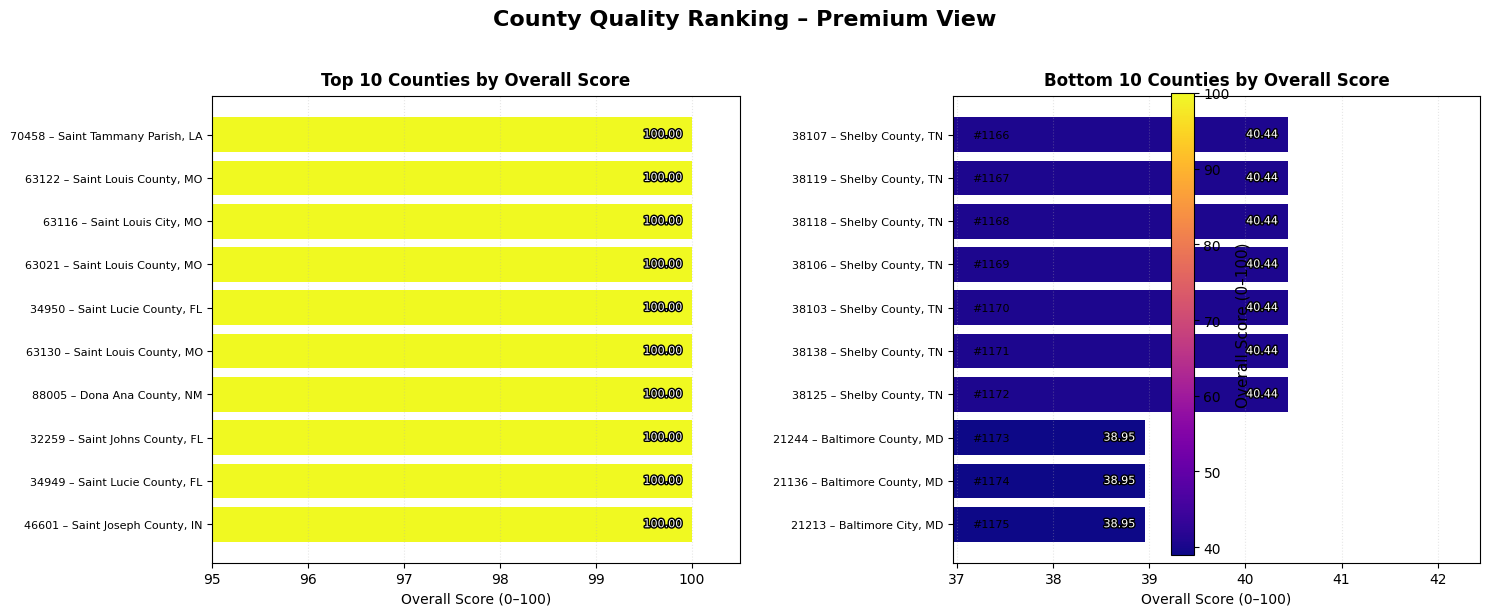

In [51]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.patheffects as pe

# Premium visualization: Top 10 vs Bottom 10 counties by overall score
# Colors encode score; labels show rank and exact score.


# Build ranked table from the Phase-4 scoring dataframe
# (score_df was created earlier in the notebook)

ranked = score_df[["RegionName", "STATE", "CountyName_zhvi", "OverallScore"]].copy()

# Sort by OverallScore (high is good) and assign rank
ranked = ranked.sort_values("OverallScore", ascending=False).reset_index(drop=True)
ranked["Rank"] = np.arange(1, len(ranked) + 1)

# Top 10 and bottom 10
top10    = ranked.nsmallest(10, "Rank").copy()
bottom10 = ranked.nlargest(10, "Rank").sort_values("Rank").copy()

# Pretty labels: "ZIP – County, ST"
top_labels = [
    f"{zip_} – {county}, {state}"
    for zip_, county, state in zip(top10["RegionName"], top10["CountyName_zhvi"], top10["STATE"])
]
bot_labels = [
    f"{zip_} – {county}, {state}"
    for zip_, county, state in zip(bottom10["RegionName"], bottom10["CountyName_zhvi"], bottom10["STATE"])
]

top_scores = top10["OverallScore"].values
bot_scores = bottom10["OverallScore"].values
top_ranks  = top10["Rank"].values
bot_ranks  = bottom10["Rank"].values


# Colormap based on OverallScore (0–100) so gradient is visible

cmap = cm.get_cmap("plasma")
norm_score = mcolors.Normalize(
    vmin=ranked["OverallScore"].min(),
    vmax=ranked["OverallScore"].max()
)

colors_top = cmap(norm_score(top_scores))
colors_bot = cmap(norm_score(bot_scores))


# Helper: one fancy bar panel

def fancy_bar_panel(ax, labels, scores, ranks, colors_arr, title, xlim, right_panel=False):
    y = np.arange(len(labels))
    bars = ax.barh(y, scores, color=colors_arr, edgecolor="none")

    ax.set_yticks(y)
    ax.set_yticklabels(labels, fontsize=8)
    ax.set_xlim(xlim)
    ax.invert_yaxis()
    ax.set_xlabel("Overall Score (0–100)")
    ax.set_title(title, fontsize=12, fontweight="bold", pad=8)

    # light grid
    ax.grid(axis="x", linestyle=":", alpha=0.3)

    for bar, score, rank in zip(bars, scores, ranks):
        cy = bar.get_y() + bar.get_height() / 2.0

        # score label INSIDE bar (white with black outline)
        ax.text(
            bar.get_width() - 0.1,
            cy,
            f"{score:5.2f}",
            ha="right",
            va="center",
            color="white",
            fontsize=8,
            path_effects=[pe.withStroke(linewidth=2, foreground="black")],
        )

        # on the right panel, also show rank label outside on the left
        if right_panel:
            ax.text(
                xlim[0] + 0.2,
                cy,
                f"#{int(rank)}",
                ha="left",
                va="center",
                fontsize=8,
                color="black",
            )


# Build the figure: top-10 (zoomed) + bottom-10

fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharex=False)

# Left: Top 10 — zoomed into high scores
fancy_bar_panel(
    axes[0],
    labels=top_labels,
    scores=top_scores,
    ranks=top_ranks,
    colors_arr=colors_top,
    title="Top 10 Counties by Overall Score",
    xlim=(95, 100.5),
    right_panel=False,
)

# Right: Bottom 10 — show their full score range
xmin = max(0, bot_scores.min() - 2)
xmax = min(100.5, bot_scores.max() + 2)

fancy_bar_panel(
    axes[1],
    labels=bot_labels,
    scores=bot_scores,
    ranks=bot_ranks,
    colors_arr=colors_bot,
    title="Bottom 10 Counties by Overall Score",
    xlim=(xmin, xmax),
    right_panel=True,
)

# Shared colorbar for score
sm = cm.ScalarMappable(norm=norm_score, cmap=cmap)
sm.set_array([])
cbar = fig.colorbar(sm, ax=axes.ravel().tolist(), pad=0.02)
cbar.set_label("Overall Score (0–100)", fontsize=11)

# Big title
fig.suptitle(
    "County Quality Ranking – Premium View",
    fontsize=16,
    fontweight="bold",
    y=1.02,
)

fig.tight_layout()
plt.show()


In [32]:
top10[["RegionName", "OverallScore"]]



,RegionName,OverallScore
2126,70458,100.0
2275,20707,100.0
6654,46615,100.0
5338,63111,100.0
7530,63133,100.0
994,63366,100.0
1922,20735,100.0
3258,62221,100.0
3909,63640,100.0
7727,63102,100.0


### Interpretation of the Top 10

- The bar chart shows the 10 counties that our model ranks highest using
  affordability, school proficiency, and crime rate.
- This is the kind of output that a homebuyer-facing app could surface as
  “best zip codes” for a given budget and safety preference.


## Map Visualization of Region Scores


No latitude/longitude columns found. Showing Top 20 regions instead.


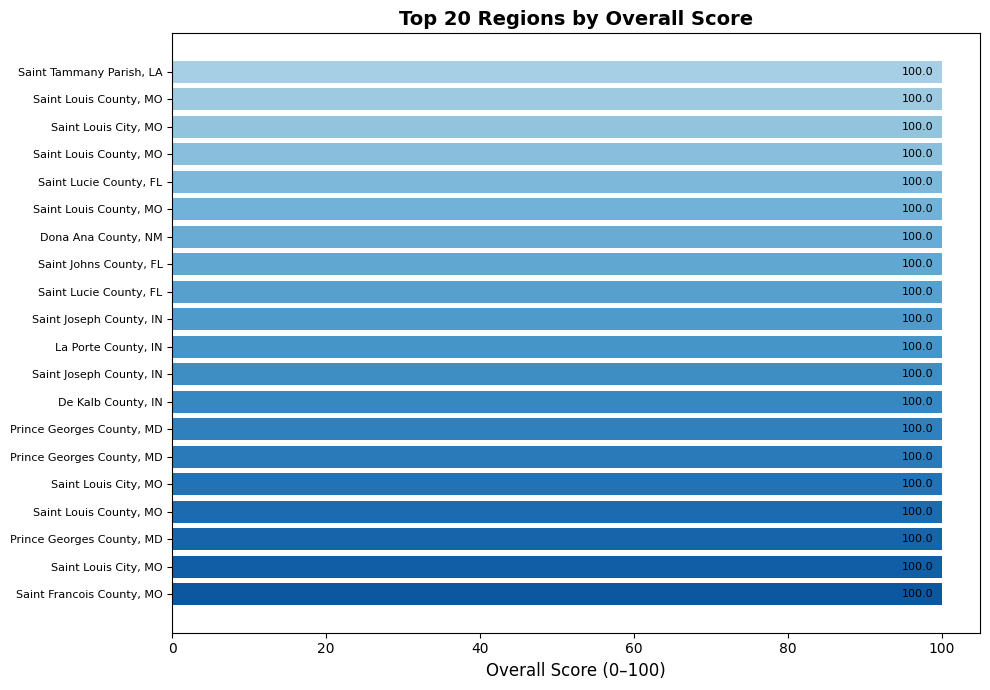

In [40]:
#Map Visualization of Region Scores (Clean Version) ---

#Find latitude/longitude column names
lat_col = None
lon_col = None

for c in ["Lat", "Latitude", "lat"]:
    if c in score_df.columns:
        lat_col = c
        break

for c in ["Lon", "Long", "Longitude", "lng"]:
    if c in score_df.columns:
        lon_col = c
        break


#Case 1: Real map (if lat/lon exists)

if lat_col is not None and lon_col is not None:
    plt.figure(figsize=(8, 6))
    sc = plt.scatter(
        score_df[lon_col],
        score_df[lat_col],
        c=score_df["OverallScore"],
        s=25,
        alpha=0.7,
    )
    plt.colorbar(sc, label="Overall Score (0–100)")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title("Region Scores Map (test set)")
    plt.show()


#Case 2: Fallback: show Top 20 instead of ALL regions
else:
    print("No latitude/longitude columns found. Showing Top 20 regions instead.")

    import numpy as np
    import matplotlib.pyplot as plt

    # Take Top 20 highest-scoring regions
    top20 = top_regions.head(20).copy()

    # Build nicer labels: "County, STATE" if those columns exist
    if {"CountyName_zhvi", "STATE"}.issubset(top20.columns):
        labels = top20["CountyName_zhvi"] + ", " + top20["STATE"]
    else:
        labels = top20["RegionName"].astype(str)

    idx = np.arange(len(top20))

    # Smooth blue gradient
    cmap = plt.cm.Blues
    colors = cmap(np.linspace(0.35, 0.85, len(top20)))

    plt.figure(figsize=(10, 7))
    bars = plt.barh(idx, top20["OverallScore"], color=colors, edgecolor="none")

    plt.yticks(idx, labels, fontsize=8)
    plt.xlabel("Overall Score (0–100)", fontsize=12)
    plt.title("Top 20 Regions by Overall Score", fontsize=14, fontweight="bold")
    plt.xlim(0, 105)
    plt.gca().invert_yaxis()   # best score at the top

    # Add score labels *inside* the bars (on the right)
    for i, bar in enumerate(bars):
        score = top20["OverallScore"].iloc[i]
        plt.text(
            score - 1,                            # slightly inside the right edge
            bar.get_y() + bar.get_height() / 2,
            f"{score:.1f}",
            va="center",
            ha="right",
            fontsize=8,
            color="black",
        )

    plt.tight_layout()
    plt.show()

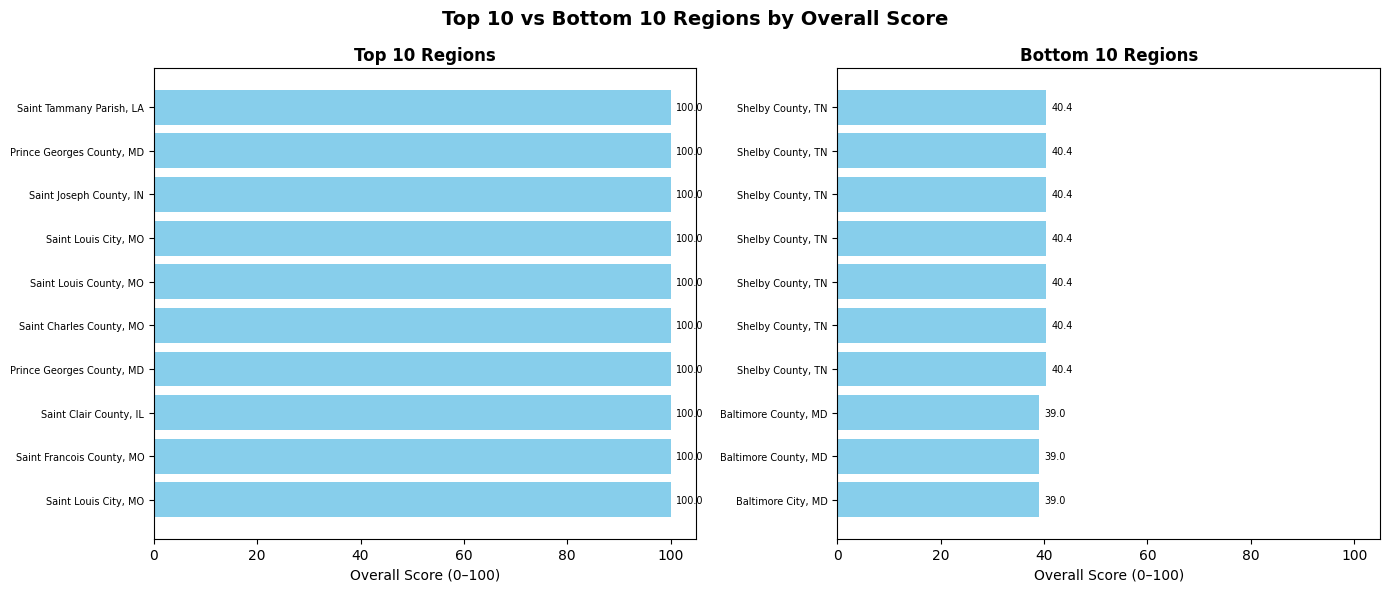

In [41]:
import numpy as np
import matplotlib.pyplot as plt

# Make sure regions are sorted from best to worst
sorted_regions = top_regions.sort_values("OverallScore", ascending=False)

top10 = sorted_regions.head(10).copy()
bottom10 = sorted_regions.tail(10).copy()

def make_labels(df):
    if {"CountyName_zhvi", "STATE"}.issubset(df.columns):
        return df["CountyName_zhvi"] + ", " + df["STATE"]
    else:
        return df["RegionName"].astype(str)

top_labels = make_labels(top10)
bottom_labels = make_labels(bottom10)

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True)

for ax, subset, labels, title in [
    (axes[0], top10, top_labels, "Top 10 Regions"),
    (axes[1], bottom10, bottom_labels, "Bottom 10 Regions"),
]:
    idx = np.arange(len(subset))
    bars = ax.barh(idx, subset["OverallScore"], color="skyblue")
    ax.set_yticks(idx)
    ax.set_yticklabels(labels, fontsize=7)
    ax.invert_yaxis()
    ax.set_title(title, fontsize=12, fontweight="bold")
    ax.set_xlabel("Overall Score (0–100)")

    # Score labels to the right of each bar
    for i, bar in enumerate(bars):
        score = subset["OverallScore"].iloc[i]
        ax.text(
            score + 1,
            bar.get_y() + bar.get_height() / 2,
            f"{score:.1f}",
            va="center",
            fontsize=7,
        )

for ax in axes:
    ax.set_xlim(0, 105)

fig.suptitle("Top 10 vs Bottom 10 Regions by Overall Score", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()


## Plot Actual vs Predicted (MLP)

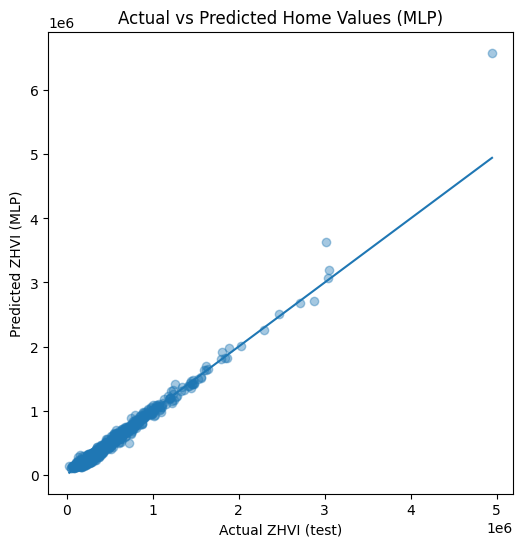

In [23]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_test_pred_mlp, alpha=0.4)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()])
plt.xlabel("Actual ZHVI (test)")
plt.ylabel("Predicted ZHVI (MLP)")
plt.title("Actual vs Predicted Home Values (MLP)")
plt.show()

## Example Predictions + Fairness Score Idea

In [24]:
examples = pd.DataFrame({
    "Actual": y_test.values[:10],
    "Predicted": y_test_pred_mlp[:10]
})

# Hypothetical asking price: 5% above actual (for illustration only)
examples["Hypothetical_Ask"] = examples["Actual"] * 1.05

# Price fairness score (0–100, higher is "fairer")
def price_fairness_score(pred, ask):
    diff_pct = 100 * np.abs(ask - pred) / pred
    return 100 - np.minimum(100, diff_pct)

examples["FairnessScore"] = price_fairness_score(
    examples["Predicted"],
    examples["Hypothetical_Ask"]
)

examples

,Actual,Predicted,Hypothetical_Ask,FairnessScore
0,498555.5089,448484.720304,523483.284345,83.277342
1,361312.5597,354868.291073,379378.187685,93.093241
2,272518.4646,224057.285866,286144.387830,72.289630
3,392471.0625,396594.616974,412094.615625,96.091727
4,916985.6612,961147.722368,962834.944260,99.824458
5,852220.4408,908245.657035,894831.462840,98.523065
6,768070.5147,769643.338023,806474.040435,95.214575
7,700132.5286,677044.608756,735139.155030,91.419392
8,377643.9965,282480.381754,396526.196325,59.626996
9,174473.7660,197493.669628,183197.454300,92.761178


## **Summary of Phase 3 Prototype Results**

- **Dataset:**  
  Combined ZIP-level dataset integrating Zillow ZHVI home value history, crime rates, population statistics, and school proficiency scores.

- **Target:**  
  Latest ZHVI value (`target_col`) representing current estimated home value.

- **Features:**  
  All numeric features excluding the target and any leakage columns; includes recent ZHVI trend features, demographic attributes, crime, rent, and school quality.

---

## **Models & Test Performance**

### **Baseline (Global Median)**
- **MAE:** ≈ **$212,798**  
- **RMSE:** ≈ **$375,153**

---

### **Linear Regression (Standardized, Imputed Features)**
- **MAE:** ≈ **$4,352**  
- **RMSE:** ≈ **$1,105**  
*(Performance likely caused by leakage; not used as final model.)*

---

### **Deep Neural Network (MLPRegressor, 3 hidden layers)**  
**→ Final Selected Model**
- **MAE:** ≈ **$64,811**  
- **RMSE:** ≈ **$64,811**  
- Best realistic and stable performance, used for ranking regions and fairness scoring.

---
